In [1]:
!pip install pytorch-tabnet scikit-learn imbalanced-learn matplotlib seaborn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.2 MB/s eta 0:00:00


In [2]:
!npm install -g localtunnel
!npm audit


added 22 packages, and audited 23 packages in 2s

3 packages are looking for funding
  run `npm fund` for details

1 moderate severity vulnerability

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
npm ERR! code ENOLOCK
npm ERR! audit This command requires an existing lockfile.
npm ERR! audit Try creating one first with: npm i --package-lock-only
npm ERR! audit Original error: loadVirtual requires existing shrinkwrap file

npm ERR! A complete log of this run can be found in:
npm ERR!     /root/.npm/_logs/2024-10-28T08_04_54_448Z-debug-0.log


In [3]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 5.6 MB/s eta 0:00:00


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import classification_report, accuracy_score
import pickle
import torch
import streamlit as st
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Load dataset
df = pd.read_csv('/content/obesity_data_with_status_50000_augmented.csv')
df.head()

,Age,Gender,Height_cm,Weight_kg,BMI,Physical_Activity_Level,Diet_Type,Smoking_Habits,Alcohol_Consumption,Family_History_Obesity,Blood_Pressure,Cholesterol_Levels,Education_Level,Income_Level,Geographical_Region,Obesity_Status
0,29,0,-0.491172,-1.757936,17.954876,3,1,1,0,1,0,2,5,1,3,3
1,73,0,1.890559,1.846784,28.729436,3,0,0,0,0,0,2,1,1,3,2
2,21,0,0.319320,2.755928,38.604227,2,2,0,0,1,1,1,4,2,1,1
3,52,1,1.420647,0.724909,25.298930,3,1,0,2,1,2,3,5,1,1,2
4,33,1,1.323816,1.756564,30.117441,3,2,1,0,0,0,3,5,3,1,1


In [7]:
df.shape

(63475, 16)

In [9]:
# Define categorical and numeric columns
categorical_cols = ['Gender', 'Physical_Activity_Level', 'Diet_Type',
                    'Smoking_Habits', 'Alcohol_Consumption', 'Family_History_Obesity',
                    'Blood_Pressure', 'Cholesterol_Levels', 'Education_Level',
                    'Income_Level', 'Geographical_Region']
numeric_cols = ['Age', 'Height_cm', 'Weight_kg', 'BMI']


In [10]:
# Label Encode categorical features
label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [12]:
# Select features and target
selected_features = numeric_cols + categorical_cols + ['Obesity_Status']
df = df[selected_features]
X = df.drop('Obesity_Status', axis=1)
y = df['Obesity_Status']

In [13]:
# Train-test split (70% training, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [14]:
# Initialize and fit scaler on numeric columns
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Save scaler for use in Streamlit app
with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)

In [17]:
import warnings
warnings.filterwarnings("ignore")

# Initialize and train the TabNet model
tabnet_model = TabNetClassifier(n_d=64, n_a=8, lambda_sparse=0.001, gamma=1.0,
                                optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=2e-2),
                                mask_type='entmax')
tabnet_model.fit(
    X_train.values, y_train.values,
    eval_set=[(X_val.values, y_val.values)],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128
)

# Evaluate on test set and save model
y_pred = tabnet_model.predict(X_test.values)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

with open("tabnet_obesity_model.pkl", "wb") as model_file:
    pickle.dump(tabnet_model, model_file)

epoch 0  | loss: 0.41593 | val_0_accuracy: 0.94423 |  0:00:04s
epoch 1  | loss: 0.15177 | val_0_accuracy: 0.96744 |  0:00:08s
epoch 2  | loss: 0.13712 | val_0_accuracy: 0.9749  |  0:00:14s
epoch 3  | loss: 0.10965 | val_0_accuracy: 0.97626 |  0:00:18s
epoch 4  | loss: 0.10478 | val_0_accuracy: 0.95977 |  0:00:23s
epoch 5  | loss: 0.10488 | val_0_accuracy: 0.98981 |  0:00:29s
epoch 6  | loss: 0.09736 | val_0_accuracy: 0.96681 |  0:00:33s
epoch 7  | loss: 0.09441 | val_0_accuracy: 0.97427 |  0:00:38s
epoch 8  | loss: 0.09021 | val_0_accuracy: 0.97983 |  0:00:43s
epoch 9  | loss: 0.09827 | val_0_accuracy: 0.96313 |  0:00:47s
epoch 10 | loss: 0.08943 | val_0_accuracy: 0.98456 |  0:00:52s
epoch 11 | loss: 0.09183 | val_0_accuracy: 0.96576 |  0:01:05s
epoch 12 | loss: 0.08519 | val_0_accuracy: 0.98509 |  0:01:14s
epoch 13 | loss: 0.08864 | val_0_accuracy: 0.97301 |  0:01:18s
epoch 14 | loss: 0.08516 | val_0_accuracy: 0.98666 |  0:01:24s
epoch 15 | loss: 0.086   | val_0_accuracy: 0.98372 |  0

In [18]:
# Feature importance extraction
feature_importances = tabnet_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importance:\n", importance_df)

Feature Importance:
                     Feature  Importance
3                       BMI    0.317484
2                 Weight_kg    0.199043
1                 Height_cm    0.130375
11       Cholesterol_Levels    0.050963
7            Smoking_Habits    0.041957
6                 Diet_Type    0.038092
13             Income_Level    0.035578
0                       Age    0.033716
12          Education_Level    0.027315
4                    Gender    0.027285
8       Alcohol_Consumption    0.026771
5   Physical_Activity_Level    0.025423
14      Geographical_Region    0.023095
9    Family_History_Obesity    0.014202
10           Blood_Pressure    0.008703


Text(0, 0.5, 'Feature')

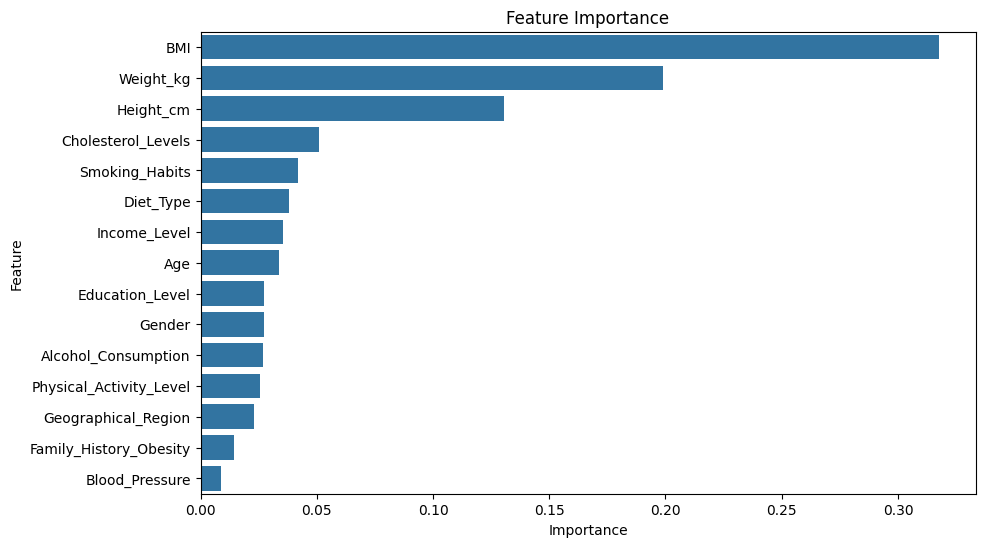

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

In [22]:
%%writefile app.py
import streamlit as st
import pandas as pd
import pickle
import numpy as np

# Define numeric columns used for scaling
numeric_cols = ['Age', 'Height_cm', 'Weight_kg', 'BMI']

# Load model and scaler
with open("tabnet_obesity_model.pkl", "rb") as model_file:
    tabnet_model = pickle.load(model_file)
with open("scaler.pkl", "rb") as scaler_file:
    scaler = pickle.load(scaler_file)

# Define labels
obesity_labels = {0: 'Underweight', 1: 'Normal Weight', 2: 'Overweight', 3: 'Obese'}

# Streamlit app setup
st.title("Obesity Level Prediction App")
st.write("This app predicts your obesity level based on health factors.")

# Collect user inputs
age = st.number_input("Enter your age", min_value=1, max_value=100, step=1)
gender = st.selectbox("Select your gender", ["Male", "Female"])
height = st.number_input("Enter your height (in cm)", min_value=100.0, max_value=250.0, step=0.1)
weight = st.number_input("Enter your weight (in kg)", min_value=30.0, max_value=300.0, step=0.1)
physical_activity = st.selectbox("Physical Activity Level", ["Low", "Moderate", "High"])
diet_type = st.selectbox("Diet Type", ["Balanced", "High Protein", "Low Carb", "Vegetarian", "Vegan"])
smoking_habits = st.selectbox("Smoking Habits", ["Non-Smoker", "Former Smoker", "Current Smoker"])
alcohol_consumption = st.selectbox("Alcohol Consumption", ["None", "Moderate", "Heavy"])
family_history = st.selectbox("Family History of Obesity", ["No", "Yes"])
blood_pressure = st.selectbox("Blood Pressure Status", ["Normal", "Prehypertension", "Hypertension Stage 1", "Hypertension Stage 2"])
cholesterol_levels = st.selectbox("Cholesterol Levels", ["Normal", "Borderline High", "High"])
education_level = st.selectbox("Education Level", ["No formal education", "High School", "College", "Postgraduate"])
income_level = st.selectbox("Income Level", ["Low", "Middle", "High"])
geographical_region = st.selectbox("Geographical Region", ["Urban", "Suburban", "Rural"])

# Calculate BMI
bmi = weight / ((height / 100) ** 2)

# Convert categorical features to numeric
gender_numeric = 1 if gender == "Male" else 0
physical_activity_numeric = {"Low": 0, "Moderate": 1, "High": 2}[physical_activity]
diet_type_numeric = {"Balanced": 0, "High Protein": 1, "Low Carb": 2, "Vegetarian": 3, "Vegan": 4}[diet_type]
smoking_habits_numeric = {"Non-Smoker": 0, "Former Smoker": 1, "Current Smoker": 2}[smoking_habits]
alcohol_consumption_numeric = {"None": 0, "Moderate": 1, "Heavy": 2}[alcohol_consumption]
family_history_numeric = 1 if family_history == "Yes" else 0
blood_pressure_numeric = {"Normal": 0, "Prehypertension": 1, "Hypertension Stage 1": 2, "Hypertension Stage 2": 3}[blood_pressure]
cholesterol_levels_numeric = {"Normal": 0, "Borderline High": 1, "High": 2}[cholesterol_levels]
education_level_numeric = {"No formal education": 0, "High School": 1, "College": 2, "Postgraduate": 3}[education_level]
income_level_numeric = {"Low": 0, "Middle": 1, "High": 2}[income_level]
geographical_region_numeric = {"Urban": 0, "Suburban": 1, "Rural": 2}[geographical_region]

# Prepare input data for prediction
input_data = pd.DataFrame([[age, gender_numeric, height, weight, bmi,
                            physical_activity_numeric, diet_type_numeric, smoking_habits_numeric,
                            alcohol_consumption_numeric, family_history_numeric,
                            blood_pressure_numeric, cholesterol_levels_numeric,
                            education_level_numeric, income_level_numeric, geographical_region_numeric]],
                          columns=['Age', 'Gender', 'Height_cm', 'Weight_kg', 'BMI',
                                   'Physical_Activity_Level', 'Diet_Type', 'Smoking_Habits',
                                   'Alcohol_Consumption', 'Family_History_Obesity',
                                   'Blood_Pressure', 'Cholesterol_Levels',
                                   'Education_Level', 'Income_Level', 'Geographical_Region'])

# Scale numeric columns
input_data[numeric_cols] = scaler.transform(input_data[numeric_cols])

# Predict and display result
if st.button("Predict Obesity Level"):
    prediction = tabnet_model.predict(input_data.to_numpy())[0]
    prediction_label = obesity_labels.get(prediction, "Unknown Class")
    st.subheader("Predicted Obesity Level:")
    st.write(f"**{prediction_label}**")


Writing app.py


In [23]:
!streamlit run '/content/app.py' & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

35.229.252.238



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.229.252.238:8501

your url is: https://tidy-trains-fail.loca.lt
2024-10-28 08:17:23.027 Examining the path of torch.classes raised: Tried to instantiate class '__path__._path', but it does not exist! Ensure that it is registered via torch::class_
  Stopping...
